### Answer Synthesis from Multiple Sources

**What Is It?**
Answer synthesis from multiple sources is the process by which an AI agent gathers information from **different retrieval tools, knowledge bases, or documents** and merges it into a **single, coherent, and contextually rich answer**.

In **Agentic RAG**, this is a core capability — the system doesn’t just retrieve information. It **plans**, **retrieves**, and then **synthesizes** an answer that draws insights from **multiple sources**.

---

**Why It’s Important**
Real-world queries are often:

* **Multifaceted** – requiring multiple types of information
* **Ambiguous or incomplete** – needing refinement
* **Open-ended** – not answerable from a single document

Relying on a single vector database or source is often insufficient.

---

**What an Agent Does**
A multi-source agent can:

* **Plan retrieval** – decide what to fetch and from where
* **Retrieve content** – gather data from multiple tools (e.g., Wikipedia, PDFs, APIs, SQL)
* **Evaluate and merge context** – consolidate relevant information
* **Generate a unified response** – produce a single, human-like answer

---

So in short:

Answer Synthesis from Multiple Sources = Combining info from multiple sources into one accurate, clear, and context-rich answer.

In [21]:
import os
from typing import List
from pydantic import BaseModel
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader,WebBaseLoader
from langgraph.graph import StateGraph, END
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.document_loaders.youtube import YoutubeLoader
from langchain_community.document_loaders import ArxivLoader
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langgraph.graph import StateGraph, END

# making the gemini as llm as to be used as an llm directly which is simple

In [ ]:
import google.generativeai as genai
import os

# --- IMPORTANT ---
# Make sure you configure your API key *before* running
genai.configure(api_key="your_api_key") 

class GeminiLLM:
    def __init__(self, model: str):
        # 1. Initialize the GenerativeModel object
        try:
            self.model = genai.GenerativeModel(model)
        except Exception as e:
            print(f"Error initializing model: {e}")
            print("Please ensure your API key is set and the model name is correct.")
            raise

    def invoke(self, prompt: str):
        # 2. Use the .generate_content() method
        response = self.model.generate_content(prompt)
        
        # 3. Access the text using response.text
        
        # Mimic LangChain's .content
        class Result:
            def __init__(self, content):
                self.content = content
        
        # 4. Pass the text content to your Result class
        return Result(content=response.text)

# --- Usage ---

# Note: "gemini-2.5" might not be a valid model name.
# Using "gemini-1.5-flash" as a common, valid example.
try:
    # Try this model name if 'gemini-1.5-flash' still fails after upgrading
    llm = GeminiLLM(model="gemini-2.5-flash")
    prompt = "Explain transformer agents and their recent evolution in AI research."
    answer = llm.invoke(prompt).content
    print(answer)

except Exception as e:
    print(f"\nAn error occurred during invocation: {e}")

Transformer Agents represent a significant evolution in AI, combining the powerful language understanding and generation capabilities of large language models (LLMs) with the autonomy and decision-making framework of traditional AI agents.

## What are Transformer Agents?

At their core, Transformer Agents are **autonomous AI systems driven by one or more large language models (LLMs)**, typically based on the Transformer architecture. Unlike simple LLMs that respond to a single prompt, agents operate in an **iterative loop**:

1.  **Perceive:** Observe their environment (read text, interpret code, receive sensor data, get API responses).
2.  **Reason/Plan:** Use the LLM's capabilities (understanding, world knowledge, logical inference) to formulate a plan, break down tasks, or decide the next action. This often involves techniques like Chain-of-Thought (CoT) or Tree-of-Thought (ToT).
3.  **Act:** Execute an action based on the plan. This could be writing code, calling an external API/t

In [23]:
file_path = "data_science_interview_cleaned.txt"

# Defines the agent's tools. These are four functions for retrieving information:

In [24]:
# 1. Load text retriever 
def load_text_retriever(file_path):
    docs = TextLoader(file_path, encoding="utf-8").load()
    splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)
    chunks = splitter.split_documents(docs)
    vs = FAISS.from_documents(chunks, embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"))
    return vs.as_retriever()

# 2. Load youtube retriever
def load_youtube_retriever():
    # Mocked YouTube transcript text
    content = """
    This video explains 
    how agentic AI systems rely on feedback loops, memory, and tool use.
    It compares them to traditional pipeline-based LLMs. 
    Temporal reasoning and autonomous tasking are emphasized.
    """
    doc = Document(page_content=content, metadata={"source": "youtube"})
    vectorstore = FAISS.from_documents([doc], embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"))
    return vectorstore.as_retriever()

# 3. Load Wikipedia retriever
def wikipedia_search(query: str) -> str:
    print("🌐 Searching Wikipedia...")
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).invoke(query)

# 4. Load Arxiv retriever
def arxiv_search(query: str) -> str:
    print("📄 Searching ArXiv...")
    results = ArxivLoader(query).load()
    return "\n\n".join(doc.page_content for doc in results[:2]) or "No relevant papers found."

In [25]:
text_retriever = load_text_retriever("data_science_interview_cleaned.txt")
youtube_retriever = load_youtube_retriever()

# State

In [26]:
# pydantic model It ensures each field has the correct type and allows automatic data validation.
# For example, if someone passes an integer instead of a string for question, Pydantic will raise an error.
class MultiSourceRAGState(BaseModel):
    question: str
    text_docs: List[Document] = [] # text_docs should be a list of Document objects, and by default, it starts as an empty list (= []).
    yt_docs: List[Document] = []
    wiki_context: str = ""
    arxiv_context: str = ""
    final_answer: str = ""

# “Retrieval Nodes”

These functions are **independent modules (nodes)** that:

* Take in the current **state** (the `MultiSourceRAGState` object)
* Retrieve data from a specific **information source** (like text files, YouTube, Wikipedia, or ArXiv)
* Then return an **updated copy** of the state that includes the new retrieved data

This structure allows **LangGraph** or other workflow frameworks to connect them in a graph sequence — each node modifies the shared “state” object and passes it on.


## `state.model_copy(update={...})` — Why Used?

Instead of modifying `state` directly, this method:

* Creates a **new immutable copy** of the Pydantic model,
* Applies the update cleanly.

This keeps your data flow **functional and safe**, avoiding shared-state mutation bugs.
Think of it as:

> “Copy the state, update just this one field, and pass the new state forward.”

---

## **How They Fit in the Workflow**


```
User Question
     │
     ▼
[retrieve_text] ─→ Adds text_docs
[retrieve_yt]   ─→ Adds yt_docs
[retrieve_wikipedia] ─→ Adds wiki_context
[retrieve_arxiv] ─→ Adds arxiv_context
     │
     ▼
   Synthesizer → Combines all info into final_answer
```

Each node updates a different part of the `MultiSourceRAGState`, and by the end of all retrievals, the state is **fully enriched** with diverse context ready for synthesis.

---
### In short:

Each function is a **retrieval node** that:

* takes the shared `state`,
* retrieves info from a unique source,
* updates that part of the state,
* and passes it forward — ready for **multi-source answer synthesis** later.


In [27]:
### Retrieval Nodes
def retrieve_text(state: MultiSourceRAGState) -> MultiSourceRAGState:
    docs = text_retriever.invoke(state.question)
    return state.model_copy(update={"text_docs": docs})

def retrieve_yt(state: MultiSourceRAGState) -> MultiSourceRAGState:
    docs = youtube_retriever.invoke(state.question)
    return state.model_copy(update={"yt_docs": docs})

def retrieve_wikipedia(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = wikipedia_search(state.question)
    return state.model_copy(update={"wiki_context": result})

def retrieve_arxiv(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = arxiv_search(state.question)
    return state.model_copy(update={"arxiv_context": result})

### Combine Context from Multiple Sources
- This section gathers and merges information from all retrieved sources
- (internal documents, YouTube transcripts, Wikipedia, and ArXiv).
- It structures them into labeled sections, making it easier for the LLM
- to understand which content came from where.
### Process Internal Documents
- For each document in state.text_docs:
-   Extract its main text using `doc.page_content`
-   Join all document texts together into one string
-   Add a clear header [Internal Docs] to indicate the source section
### Model Response Handling
- After sending the combined context and question to the LLM:
-   `.content` extracts the textual output (model’s generated answer)
-   `.strip()` cleans up any leading or trailing spaces or line breaks
### Update State
- Create a new state object identical to the previous one,
- but with the `final_answer` field updated to include
- the synthesized response generated by the LLM.

In [28]:
## synthesize
def synthesize_answer(state: MultiSourceRAGState) -> MultiSourceRAGState:
    
    context = "" 
    context += "\n\n[Internal Docs]\n" + "\n".join([doc.page_content for doc in state.text_docs]) 
    context += "\n\n[YouTube Transcript]\n" + "\n".join([doc.page_content for doc in state.yt_docs])
    context += "\n\n[Wikipedia]\n" + state.wiki_context
    context += "\n\n[ArXiv]\n" + state.arxiv_context

    prompt = f"""You have retrieved relevant context from multiple sources. Now synthesize a complete and coherent answer.

Question: {state.question}

Context:
{context}

Final Answer:"""

    answer = llm.invoke(prompt).content.strip() 
    return state.model_copy(update={"final_answer": answer}) 

# StateGraph

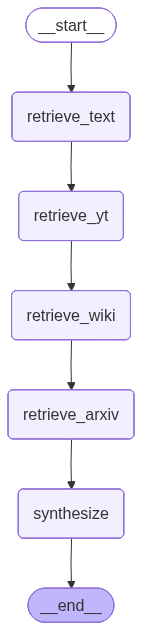

In [29]:
builder = StateGraph(MultiSourceRAGState)

builder.add_node("retrieve_text", retrieve_text)
builder.add_node("retrieve_yt", retrieve_yt)
builder.add_node("retrieve_wiki", retrieve_wikipedia)
builder.add_node("retrieve_arxiv", retrieve_arxiv)
builder.add_node("synthesize", synthesize_answer)

builder.set_entry_point("retrieve_text")
builder.add_edge("retrieve_text", "retrieve_yt")
builder.add_edge("retrieve_yt", "retrieve_wiki")
builder.add_edge("retrieve_wiki", "retrieve_arxiv")
builder.add_edge("retrieve_arxiv", "synthesize")
builder.add_edge("synthesize", END)

graph = builder.compile()
graph

In [30]:
question = "what is data science? Explain in detail using references from youtube, wikipedia, arxiv and internal documents."
state = MultiSourceRAGState(question=question)
result = graph.invoke(state)

print("✅ Final Answer:\n")
print(result["final_answer"])


🌐 Searching Wikipedia...
📄 Searching ArXiv...
✅ Final Answer:

Data Science is an interdisciplinary field that leverages a variety of scientific procedures, algorithms, tools, and machine learning techniques to extract valuable insights and create meaningful patterns from data. It integrates knowledge and methods from several foundational areas, including statistics, computer science, machine learning, deep learning, data analysis, and data visualization [Internal Docs].

Here's a detailed explanation incorporating insights from the provided sources:

1.  **Core Definition and Purpose (Internal Documents):**
    At its heart, Data Science is about making sense of vast amounts of information. It is defined as "an interdisciplinary discipline that encompasses a variety of scientific procedures, algorithms, tools, and machine learning algorithms... and creates patterns from which valuable insights may be extracted." Its primary goal is to "make connections and solve challenges in the futu

In [31]:
result

{'question': 'what is data science? Explain in detail using references from youtube, wikipedia, arxiv and internal documents.',
 'text_docs': [Document(id='6ef98c5f-41cb-41d7-9e31-7adacc9c79ba', metadata={'source': 'data_science_interview_cleaned.txt'}, page_content='employment roles of the twenty-first century.\nBackground Interview Questions and Solutions\n1. What exactly does the term "Data Science" mean?\nData Science is an interdisciplinary discipline that encompasses a variety of\nscientific procedures, algorithms, tools, and machine learning algorithms'),
  Document(id='b8bec5b3-efb3-4b80-808f-28b6c6eb7002', metadata={'source': 'data_science_interview_cleaned.txt'}, page_content='it, and creates patterns from which valuable insights may be extracted.\nData science is based on a foundation of statistics, computer science,\nmachine learning, deep learning, data analysis, data visualization, and a\nvariety of other technologies.'),
  Document(id='ec9786b0-e4eb-4c59-8ae7-1758162c270